# Simulation of extreme cone positions

This is the ipython notebook that supplements the tutorial [Simulation of extreme cone positions](https://github.com/atsu-kotani/HumanColorVision/blob/main/Website/tutorials/03_CustomSimulation.md#simulation-of-extreme-cone-positions).

Before running these codes, please make sure you have installed the required packages and set up the environment as described in the [Getting Started](https://github.com/atsu-kotani/HumanColorVision/blob/main/Website/tutorials/00_GettingStarted.md).

Also, make sure you have selected the correct python kernel (e.g. `HumanColorVision`).

---

# Setup

In [2]:
# Load root configuration
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', '..'))
from root_config import ROOT_DIR, DEVICE

# Matplotlib settings for later use in visualization
from matplotlib import font_manager
import matplotlib.pyplot as plt
font_manager.fontManager.addfont(f"{ROOT_DIR}/Tutorials/data/Futura.ttc")
prop = font_manager.FontProperties(fname=f"{ROOT_DIR}/Tutorials/data/Futura.ttc")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = prop.get_name()


# Pre-import all the necessary modules
import yaml
import torch
import IPython
import numpy as np
from PIL import Image
import imageio.v2 as imageio
import torch.nn.functional as F
from Experiment.helper import compute_required_image_resolution, largest_valid_region_square

In [3]:
# Pre-define the helper functions for later use

def load_sRGB_image(retina, image_path, params):
    # Loading the input stimulus
    MSS = params['RetinaModel']['max_shift_size']
    current_image_resolution = retina.required_image_resolution + MSS * 2

    image = Image.open(image_path).convert('RGB')
    H, W = image.size
    if H != W:
        if H > W:
            # crop the image
            image = image.crop((0, (H-W)//2, W, (H+W)//2))
        else:
            # crop the image
            image = image.crop(((W-H)//2, 0, (W+H)//2, H))

    image = image.resize((current_image_resolution, current_image_resolution), Image.Resampling.LANCZOS)
    image = np.asarray(image).copy() / 255.0
    image_tensor = torch.FloatTensor(image).to(DEVICE)
    return image_tensor

In [4]:
# First, instantiate two retina models
# 1. Horizontal streak fovea
# 2. Two foveas

from Simulated.Retina.RetinaModel import RetinaModel

# DEFAULT RETINA MODEL
with open(f'{ROOT_DIR}/Tutorials/03_CustomSimulation/Config/Default.yaml', 'r') as f:
    default_params = yaml.safe_load(f)
retina_model_default = RetinaModel(default_params)

# Load the default parameters for the trichromatic retina simulation
with open(f'{ROOT_DIR}/Tutorials/03_CustomSimulation/Config/HorizontalStreak.yaml', 'r') as f:
    horizontal_streak_params = yaml.safe_load(f)
retina_model_horizontal_streak = RetinaModel(horizontal_streak_params)

# Load the parameters for the anomalous trichromatic retina simulation
with open(f'{ROOT_DIR}/Tutorials/03_CustomSimulation/Config/TwoFoveas.yaml', 'r') as f:
    two_foveas_params = yaml.safe_load(f)
retina_model_two_foveas = RetinaModel(two_foveas_params)

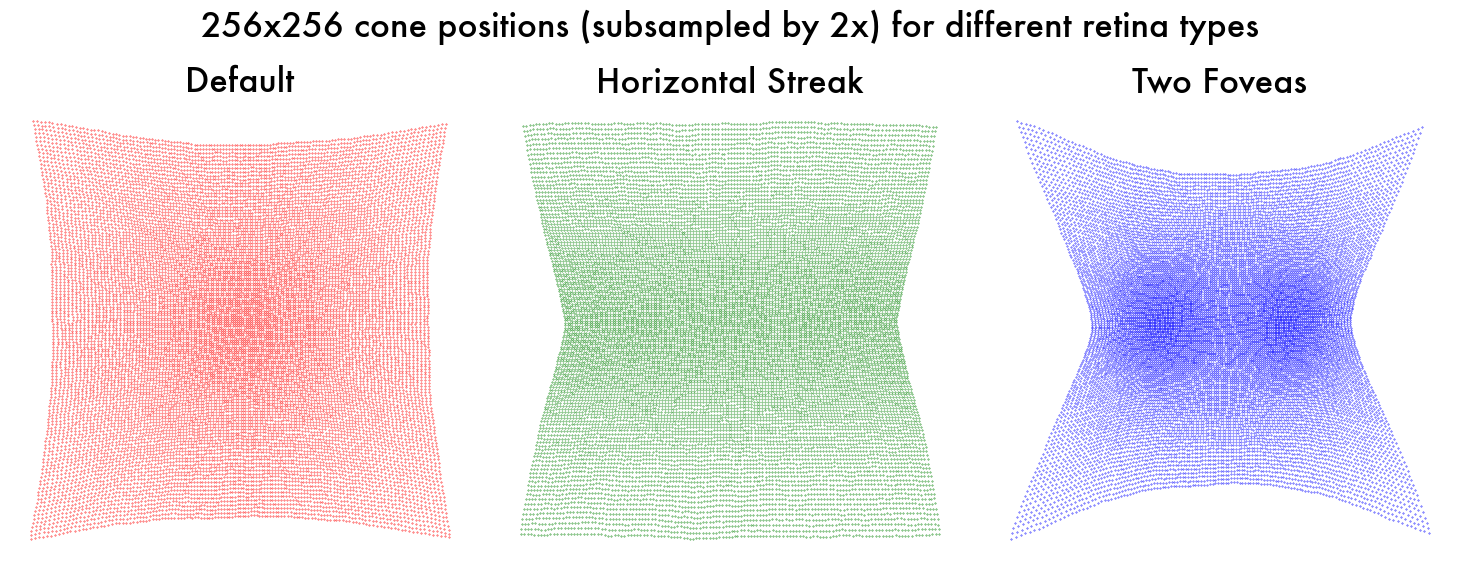

In [9]:
default_cone_locs = retina_model_default.SpatialSampling.cone_locs
horizontal_streak_cone_locs = retina_model_horizontal_streak.SpatialSampling.cone_locs
two_foveas_cone_locs = retina_model_two_foveas.SpatialSampling.cone_locs

subsample = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].scatter(default_cone_locs[::subsample,::subsample, 0], default_cone_locs[::subsample,::subsample, 1], c='r', label='Default', s=0.1)
axs[0].set_title('Default')
axs[0].set_axis_off()
axs[0].set_aspect('equal')      
axs[1].scatter(horizontal_streak_cone_locs[::subsample,::subsample, 0], horizontal_streak_cone_locs[::subsample,::subsample, 1], c='g', label='Horizontal Streak', s=0.1)
axs[1].set_title('Horizontal Streak')
axs[1].set_axis_off()
axs[1].set_aspect('equal')
axs[2].scatter(two_foveas_cone_locs[::subsample,::subsample, 0], two_foveas_cone_locs[::subsample,::subsample, 1], c='b', label='Two Foveas', s=0.1)
axs[2].set_title('Two Foveas')
axs[2].set_axis_off()
axs[2].set_aspect('equal')
fig.suptitle(f'256x256 cone positions (subsampled by {subsample}x) for different retina types')
plt.tight_layout()
plt.savefig(f'{ROOT_DIR}/Tutorials/data/custom_sim/cone_positions_comparison.png', dpi=300)
plt.show()
plt.close()


In [7]:
# You can change the example_image_path to the path of your own image
example_image_path = f'{ROOT_DIR}/Tutorials/data/sample_sRGB_image.png'

# Default retina simulation
example_sRGB_image = load_sRGB_image(retina_model_default, example_image_path, default_params)
example_linsRGB_image = retina_model_default.CST.sRGB_to_linsRGB(example_sRGB_image)
example_LMS_image = retina_model_default.CST.linsRGB_to_LMS(example_linsRGB_image)
example_LMS_image = example_LMS_image.unsqueeze(0).permute(0, 3, 1, 2)

with torch.no_grad(): # gradient computation is not needed for retina simulation
    list_of_retinal_responses = retina_model_default.forward(example_LMS_image, intermediate_outputs=True)
    optic_nerve_signals_default = list_of_retinal_responses[0]
    photoreceptor_activation_default = list_of_retinal_responses[3]

# Horizontal streak retina simulation
example_sRGB_image = load_sRGB_image(retina_model_horizontal_streak, example_image_path, horizontal_streak_params)
example_linsRGB_image = retina_model_horizontal_streak.CST.sRGB_to_linsRGB(example_sRGB_image)
example_LMS_image = retina_model_horizontal_streak.CST.linsRGB_to_LMS(example_linsRGB_image)
example_LMS_image = example_LMS_image.unsqueeze(0).permute(0, 3, 1, 2)

with torch.no_grad(): # gradient computation is not needed for retina simulation
    list_of_retinal_responses = retina_model_horizontal_streak.forward(example_LMS_image, intermediate_outputs=True)
    optic_nerve_signals_horizontal_streak = list_of_retinal_responses[0]
    photoreceptor_activation_horizontal_streak = list_of_retinal_responses[3]

# Two foveas retina simulation
example_sRGB_image = load_sRGB_image(retina_model_two_foveas, example_image_path, two_foveas_params)
example_linsRGB_image = retina_model_two_foveas.CST.sRGB_to_linsRGB(example_sRGB_image)
example_LMS_image = retina_model_two_foveas.CST.linsRGB_to_LMS(example_linsRGB_image)
example_LMS_image = example_LMS_image.unsqueeze(0).permute(0, 3, 1, 2)

with torch.no_grad(): # gradient computation is not needed for retina simulation
    list_of_retinal_responses = retina_model_two_foveas.forward(example_LMS_image, intermediate_outputs=True)
    optic_nerve_signals_two_foveas = list_of_retinal_responses[0]
    photoreceptor_activation_two_foveas = list_of_retinal_responses[3]

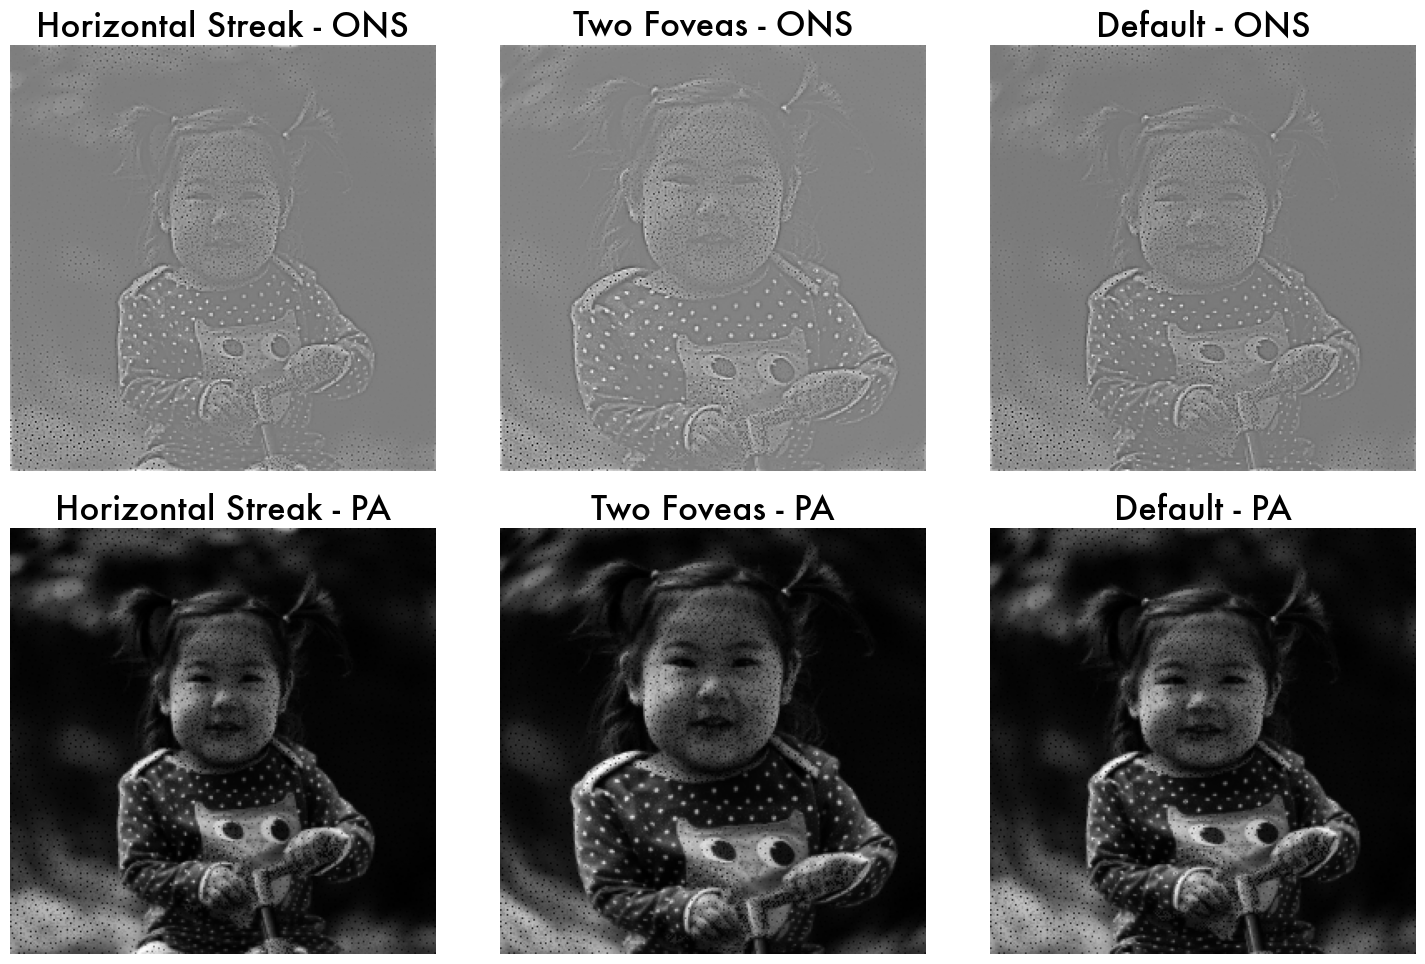

In [8]:
# 2x2 grid of images
optic_nerve_signals_default_numpy = optic_nerve_signals_default[0,0].cpu().detach().numpy()
optic_nerve_signals_horizontal_streak_numpy = optic_nerve_signals_horizontal_streak[0,0].cpu().detach().numpy()
optic_nerve_signals_two_foveas_numpy = optic_nerve_signals_two_foveas[0,0].cpu().detach().numpy()

photoreceptor_activation_default_numpy = photoreceptor_activation_default[0,0].cpu().detach().numpy()
photoreceptor_activation_horizontal_streak_numpy = photoreceptor_activation_horizontal_streak[0,0].cpu().detach().numpy()
photoreceptor_activation_two_foveas_numpy = photoreceptor_activation_two_foveas[0,0].cpu().detach().numpy()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


axs[0, 0].imshow(optic_nerve_signals_horizontal_streak_numpy, cmap='gray')
axs[0, 0].set_title('Horizontal Streak - ONS')
axs[0, 0].set_axis_off()
axs[0, 1].imshow(optic_nerve_signals_two_foveas_numpy, cmap='gray')
axs[0, 1].set_title('Two Foveas - ONS')
axs[0, 1].set_axis_off()
axs[0, 2].imshow(optic_nerve_signals_default_numpy, cmap='gray')
axs[0, 2].set_title('Default - ONS')
axs[0, 2].set_axis_off()

axs[1, 0].imshow(photoreceptor_activation_horizontal_streak_numpy, cmap='gray')
axs[1, 0].set_title('Horizontal Streak - PA')
axs[1, 0].set_axis_off()
axs[1, 1].imshow(photoreceptor_activation_two_foveas_numpy, cmap='gray')
axs[1, 1].set_title('Two Foveas - PA')
axs[1, 1].set_axis_off()
axs[1, 2].imshow(photoreceptor_activation_default_numpy, cmap='gray')
axs[1, 2].set_title('Default - PA')
axs[1, 2].set_axis_off()

plt.tight_layout()
os.makedirs(f'{ROOT_DIR}/Tutorials/data/custom_sim', exist_ok=True)
plt.savefig(f'{ROOT_DIR}/Tutorials/data/custom_sim/horizontal_streak_vs_two_foveas.png', dpi=300)
plt.show()
plt.close()